<a href="https://colab.research.google.com/github/arzss-code/jobsheet-machine-learning/blob/main/Tensorflow_dan_Keras_Lanjutan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Atsiila Arya Nabiih - 4.33.23.1.04 - TI-2B

---



Dengan menggunakan pengetahuan yang Anda dapatkan pada sesi kali ini, pergunakan teknik **Hyperparameter Tuning** dan **callbacks** untuk mendapatkan hasil yang lebih baik daripada pada sesi seblumnya:
1. Kasus Regresi: https://www.kaggle.com/datasets/prathamtripathi/regression-with-neural-networking
2. Kasus Klasifikasi: https://www.kaggle.com/datasets/deepu1109/star-dataset

# Regresi - Concrete Strength Prediction

Setup Environment

In [ ]:
# Python ≥3.5 required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import pandas as pd

# Seed untuk reproduktibilitas
np.random.seed(42)
tf.random.set_seed(42)

# Konfigurasi plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Path penyimpanan gambar
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "concrete"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Load Dataset

In [ ]:
try:
    concrete = pd.read_csv("concrete_data.csv")
except FileNotFoundError:
    print("Error: File tidak ditemukan. Pastikan 'concrete_data.csv' ada di direktori yang benar!")

# Tampilkan 5 baris pertama
print("\nData samples:")
display(concrete.head())


Data samples:


,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split features dan target
X = concrete.drop("Strength", axis=1)
y = concrete["Strength"]

# Split data
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=42  # 0.25 x 0.8 = 0.2
)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print("\nData shapes:")
print("Train:", X_train.shape)
print("Validation:", X_valid.shape)
print("Test:", X_test.shape)


Data shapes:
Train: (618, 8)
Validation: (206, 8)
Test: (206, 8)


Callback & Hyperparameter Setup

In [ ]:
# Callback & Hyperparameter Setup
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import keras_tuner as kt
from tensorflow.keras.models import load_model

checkpoint_cb = ModelCheckpoint("concrete_best_model.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)
log_dir = os.path.join("logs", "concrete")
tensorboard_cb = TensorBoard(log_dir=log_dir)

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(hp.Int("units_1", 32, 128, step=32), activation="relu", input_shape=X_train.shape[1:]))
    model.add(tf.keras.layers.Dense(hp.Int("units_2", 16, 64, step=16), activation="relu"))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss="mean_squared_error",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])))
    return model

Hyperparameter Tuning

In [ ]:
# Hyperparameter Tuning
tuner = kt.RandomSearch(build_model,
                        objective='val_loss',
                        max_trials=10,
                        executions_per_trial=1,
                        directory='keras_tuner',
                        project_name='concrete_regression')

tuner.search(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid),
             callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Reloading Tuner from keras_tuner/concrete_regression/tuner0.json


Load Best Model

In [ ]:

best_model = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
print(best_hp.values)

Best Hyperparameters:
{'units_1': 96, 'units_2': 64, 'learning_rate': 0.01}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Evaluation

In [ ]:
# Evaluate Best Model
mse_test = best_model.evaluate(X_test, y_test)
print(f"\nTest MSE: {mse_test:.4f}")
print(f"Test RMSE: {np.sqrt(mse_test):.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 41.1553  

Test MSE: 42.7654
Test RMSE: 6.5395


Visualization

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Saving figure concrete_strength_comparison


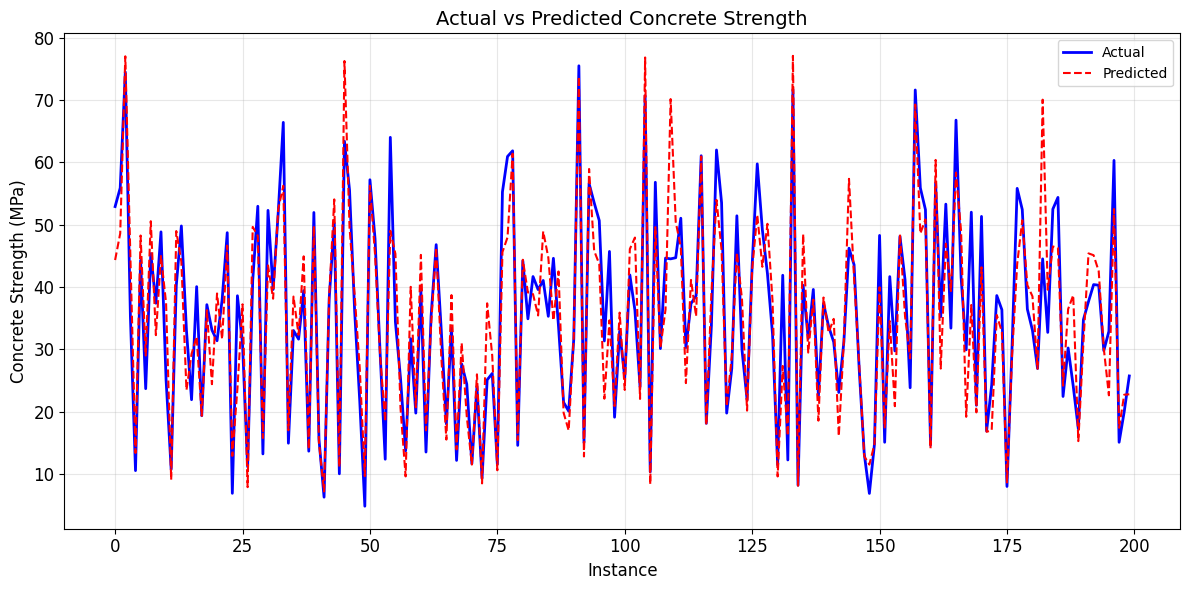

In [ ]:
plt.figure(figsize=(12,6))

# Plot 200 sampel pertama
plt.plot(y_test.values[:200], "b-", linewidth=2, label="Actual")
plt.plot(best_model.predict(X_test[:200]).flatten(), "r--", linewidth=1.5, label="Predicted")
plt.xlabel("Instance", fontsize=12)
plt.ylabel("Concrete Strength (MPa)", fontsize=12)
plt.title("Actual vs Predicted Concrete Strength", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
save_fig("concrete_strength_comparison")
plt.show()

Save & Restore Model

In [ ]:

best_model.save("concrete_final_model.h5")
print("Model saved.")

restored_model = load_model("concrete_final_model.h5")
print("Model loaded.")

restored_loss = restored_model.evaluate(X_test, y_test)
print(f"Restored model test MSE: {restored_loss:.4f}")

Model saved.
Model loaded.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 41.1553  
Restored model test MSE: 42.7654


# Klasifikasi - Star Type Classification


Setup Environment

In [ ]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import tensorflow as tf
assert tf.__version__ >= "2.0"

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Seed setup
np.random.seed(42)
tf.random.set_seed(42)

# Plot config
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# Save figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "stars"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Load Data

In [ ]:
try:
    stars = pd.read_csv("6_class.csv")
except FileNotFoundError:
    print("Error: File 6_class.csv tidak ditemukan!")

print("\nData samples:")
display(stars.head())


Data samples:


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Clean and map star colors
color_mapping = {
    'red': 'red',
    'blue white': 'blue_white',
    'white': 'white',
    'yellowish white': 'yellow_white',
    'yellowish': 'yellow',
    'orange red': 'orange_red'
}
stars['Star color'] = stars['Star color'].str.lower().str.replace('-', ' ').str.strip().map(color_mapping).fillna('other')

# One-hot encoding
stars_encoded = pd.get_dummies(stars, columns=['Star color', 'Spectral Class'])

# Split features and target
X = stars_encoded.drop('Star type', axis=1)
y = stars_encoded['Star type']

# Split data
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=42
)

# Scale numerical features
scaler = StandardScaler()
num_cols = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_valid[num_cols] = scaler.transform(X_valid[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("\nData shapes:")
print("Train:", X_train.shape)
print("Validation:", X_valid.shape)
print("Test:", X_test.shape)


Data shapes:
Train: (144, 18)
Validation: (48, 18)
Test: (48, 18)


Hyperparameter Tuning

In [ ]:

import keras_tuner as kt
from tensorflow import keras

def build_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(
        hp.Int("units_1", min_value=32, max_value=128, step=32),
        activation="relu",
        input_shape=[X_train.shape[1]]
    ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(hp.Float("dropout", 0.2, 0.5, step=0.1)))
    model.add(keras.layers.Dense(
        hp.Int("units_2", min_value=16, max_value=64, step=16),
        activation="relu"
    ))
    model.add(keras.layers.Dense(6, activation="softmax"))

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="keras_tuner_stars",
    project_name="star_type_classification"
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), callbacks=callbacks)


Reloading Tuner from keras_tuner_stars/star_type_classification/tuner0.json


Callbacks

In [ ]:
# Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint("best_star_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
callbacks = [checkpoint_cb, early_stopping_cb]


Run Tuning

In [ ]:

tuner.search(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), callbacks=callbacks)
best_hp = tuner.get_best_hyperparameters(1)[0]


Train Ulang dengan Best Hyperparameter

In [ ]:

model = build_model(best_hp)

history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1562 - loss: 2.7894

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.4482 - loss: 1.7824 - val_accuracy: 0.6250 - val_loss: 1.2552
Epoch 2/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step - accuracy: 0.6875 - loss: 0.7303

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7558 - loss: 0.5906 - val_accuracy: 0.7292 - val_loss: 1.0710
Epoch 3/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8750 - loss: 0.4502

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8863 - loss: 0.3952 - val_accuracy: 0.7708 - val_loss: 0.9753
Epoch 4/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9688 - loss: 0.3814

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9729 - loss: 0.3156 - val_accuracy: 0.7917 - val_loss: 0.8999
Epoch 5/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9688 - loss: 0.2987

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9686 - loss: 0.2391 - val_accuracy: 0.8542 - val_loss: 0.8116
Epoch 6/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9375 - loss: 0.2590

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9598 - loss: 0.1987 - val_accuracy: 0.8125 - val_loss: 0.7697
Epoch 7/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0834

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9897 - loss: 0.1019 - val_accuracy: 0.8542 - val_loss: 0.7079
Epoch 8/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0524

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9920 - loss: 0.0580 - val_accuracy: 0.8542 - val_loss: 0.6118
Epoch 9/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0225

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0235 - val_accuracy: 0.8750 - val_loss: 0.5256
Epoch 10/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.0152

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0170 - val_accuracy: 0.8958 - val_loss: 0.4409
Epoch 11/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0087

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9964 - loss: 0.0232 - val_accuracy: 0.8958 - val_loss: 0.4125
Epoch 12/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9688 - loss: 0.0734

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9709 - loss: 0.0677 - val_accuracy: 0.9792 - val_loss: 0.3555
Epoch 13/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9688 - loss: 0.0347

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9716 - loss: 0.0552 - val_accuracy: 0.9167 - val_loss: 0.3484
Epoch 14/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9688 - loss: 0.0313

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9868 - loss: 0.0250 - val_accuracy: 0.9583 - val_loss: 0.3401
Epoch 15/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0055

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0130 - val_accuracy: 0.9583 - val_loss: 0.3320
Epoch 16/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 1.0000 - loss: 0.0294

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0196 - val_accuracy: 0.9583 - val_loss: 0.2975
Epoch 17/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9977 - loss: 0.0211 - val_accuracy: 0.8750 - val_loss: 0.3239
Epoch 18/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9920 - loss: 0.0178 - val_accuracy: 0.9583 - val_loss: 0.3639
Epoch 19/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9897 - loss: 0.0360 - val_accuracy: 0.9583 - val_loss: 0.3904
Epoch 20/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0083 - val_accuracy: 0.8958 - val_loss: 0.3475
Epoch 21/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 0.8958 - val_loss: 0.3199
Epoch 22/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9688 - loss: 0.0712

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9789 - loss: 0.0390 - val_accuracy: 0.9583 - val_loss: 0.2938
Epoch 23/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9867 - loss: 0.0392 - val_accuracy: 0.8542 - val_loss: 0.3667
Epoch 24/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 1.0000 - loss: 0.0033

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.0095 - val_accuracy: 0.9167 - val_loss: 0.2710
Epoch 25/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9920 - loss: 0.0182 - val_accuracy: 0.8542 - val_loss: 0.3062
Epoch 26/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9688 - loss: 0.0440

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9868 - loss: 0.0241 - val_accuracy: 0.9167 - val_loss: 0.2581
Epoch 27/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 0.0015

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9583 - val_loss: 0.2311
Epoch 28/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.9375 - val_loss: 0.2487
Epoch 29/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.9375 - val_loss: 0.2336
Epoch 30/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0064

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.9583 - val_loss: 0.1926
Epoch 31/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 4.5379e-04

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.9583 - val_loss: 0.1921
Epoch 32/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.8958 - val_loss: 0.2264
Epoch 33/50
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0012

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9920 - loss: 0.0129 - val_accuracy: 0.9583 - val_loss: 0.1860
Epoch 34/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9753 - loss: 0.0485 - val_accuracy: 0.9167 - val_loss: 0.2146
Epoch 35/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 0.9375 - val_loss: 0.2092
Epoch 36/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.9375 - val_loss: 0.2139
Epoch 37/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9964 - loss: 0.0086 - val_accuracy: 0.9583 - val_loss: 0.1861
Epoch 38/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9920 - loss: 0.0178 - val_accuracy: 0.8750 - val_loss: 0.2888
Epoch 39/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9868 - loss: 0.1013 - val_accuracy: 0.9583 - val_loss: 0.1934
Epoch 40/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9884 - loss: 0.0203 - val_accuracy: 0.9583 - val_loss: 0.2087
Epoc

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9964 - loss: 0.0060 - val_accuracy: 0.9583 - val_loss: 0.1766
Epoch 42/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 0.8750 - val_loss: 0.2726
Epoch 43/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.9583 - val_loss: 0.1918
Epoch 44/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9964 - loss: 0.0125 - val_accuracy: 0.9167 - val_loss: 0.2074
Epoch 45/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9920 - loss: 0.0135 - val_accuracy: 0.9583 - val_loss: 0.1850
Epoch 46/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 0.9583 - val_loss: 0.1924
Epoch 47/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.9583 - val_loss: 0.1819
Epoch 48/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.8958 - val_loss: 0.2421
Epoc

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9920 - loss: 0.0158 - val_accuracy: 0.9583 - val_loss: 0.1593
Epoch 50/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9805 - loss: 0.0413 - val_accuracy: 0.8542 - val_loss: 0.3891


Learning Curve

Saving figure stars_learning_curves


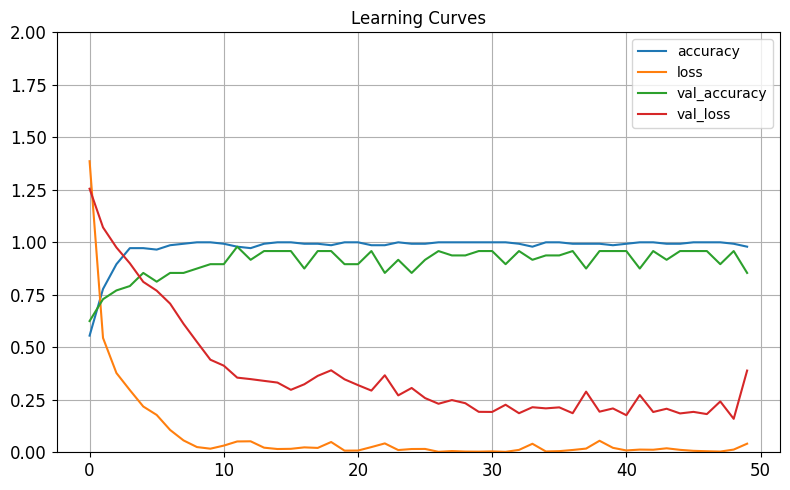

In [ ]:
# Plot Learning Curve
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.title("Learning Curves")
save_fig("stars_learning_curves")
plt.show()


Evaluate

In [ ]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0463

Test Accuracy: 1.0000


Visualization

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48

Saving figure stars_confusion_matrix


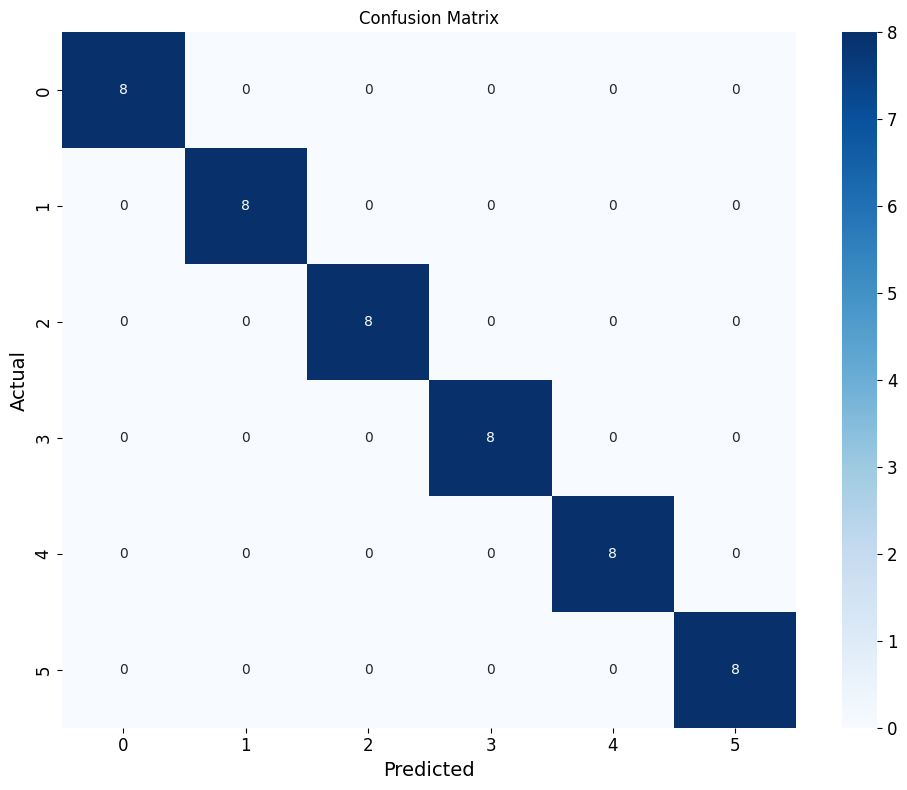


Sample Predictions (5 instances):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Instance 1:
True Class: 1 | Predicted: 1
Class probabilities: [0.33  0.619 0.011 0.012 0.028 0.001]

Instance 2:
True Class: 3 | Predicted: 3
Class probabilities: [0.    0.    0.    0.999 0.001 0.   ]

Instance 3:
True Class: 1 | Predicted: 1
Class probabilities: [0.007 0.979 0.001 0.007 0.007 0.   ]

Instance 4:
True Class: 0 | Predicted: 0
Class probabilities: [0.991 0.002 0.002 0.    0.004 0.   ]

Instance 5:
True Class: 4 | Predicted: 4
Class probabilities: [0.    0.    0.    0.    0.999 0.001]


In [ ]:
# Classification Report
from sklearn.metrics import classification_report
y_pred = np.argmax(model.predict(X_test), axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
save_fig("stars_confusion_matrix")
plt.show()


# Sample Predictions
print("\nSample Predictions (5 instances):")
sample_data = X_test.iloc[:5]
probabilities = model.predict(sample_data)
predicted_classes = np.argmax(probabilities, axis=1)

for i, (true, pred, prob) in enumerate(zip(y_test.iloc[:5], predicted_classes, probabilities)):
    print(f"\nInstance {i+1}:")
    print(f"True Class: {true} | Predicted: {pred}")
    print(f"Class probabilities: {np.round(prob, 3)}")
